## Monte Carlo Algo (Prediction):
#### First Visit and Every Visit

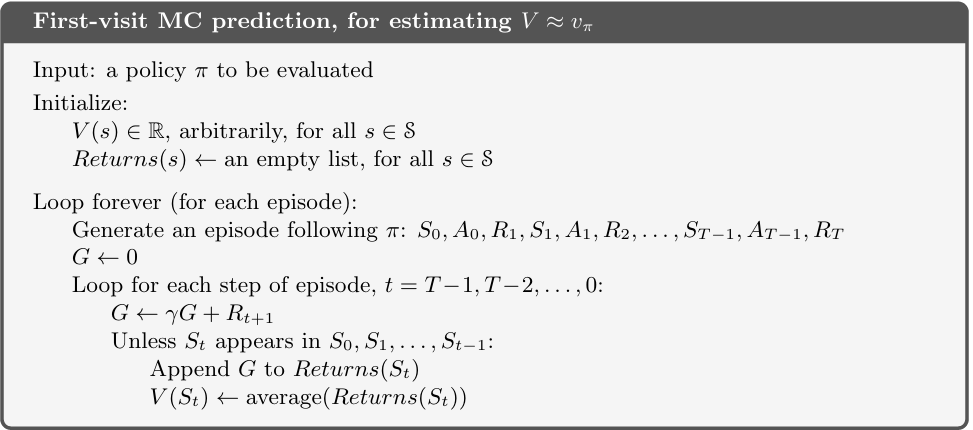

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from Monte_carlo_helper import *

Observation Space ---> (Player_sum,Dealer_Card,Useable_Ace) ----> ((2->21),(1->10),(1,0))  
Action Space ------> (Hit,Stick) ----> (1,0)

In [2]:
def MC(env,policy,gamma=1,n_episodes=100000,method="first-visit"):
    v= {}
    count = {}
    for _ in range(n_episodes):
        states,_,rewards = generate_episode(env,policy)
        G = 0
        visited_states = set()
        for t in range(len(states)-1,-1,-1):
            S = states[t]
            G = G*gamma +rewards[t]
            if method == "first-visit" and states[t] in visited_states:
                continue  # Skip if already visited (first-visit MC)
            visited_states.add(S)
            if S not in count:
                count[S] = 0
                v[S] = 0
            count[S]+=1
            v[S] += (G-v[S])/(np.maximum(count[S], 1))
            
    return v

In [3]:
env = gym.make('Blackjack-v1',sab=True)

In [4]:
policy1 = {(p,d,a):[0,1] if p<20 else [1,0] for p in range(32) for d in range(11) for a in range(2)}
value1 = MC(env,policy1, n_episodes=500000,method="first-visit")
value2 = MC(env,policy1, n_episodes=500000,method="every-visit")


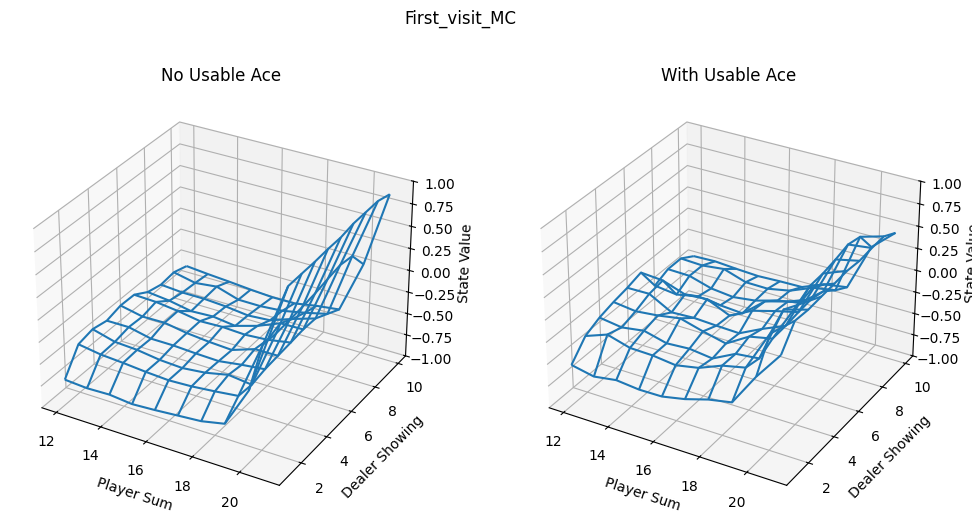

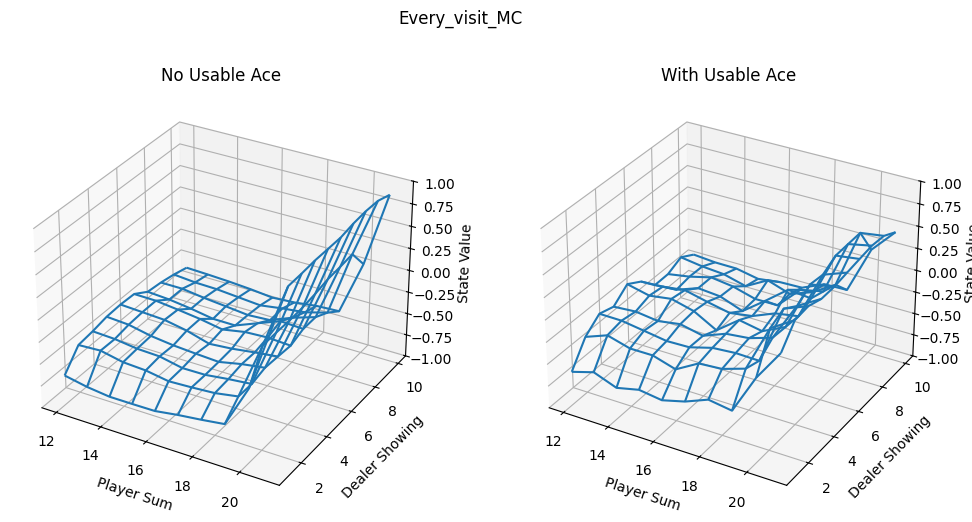

In [5]:

plot_blackjack_V(value1,'First_visit_MC')
plot_blackjack_V(value2,'Every_visit_MC')

## Off Policy Prediction

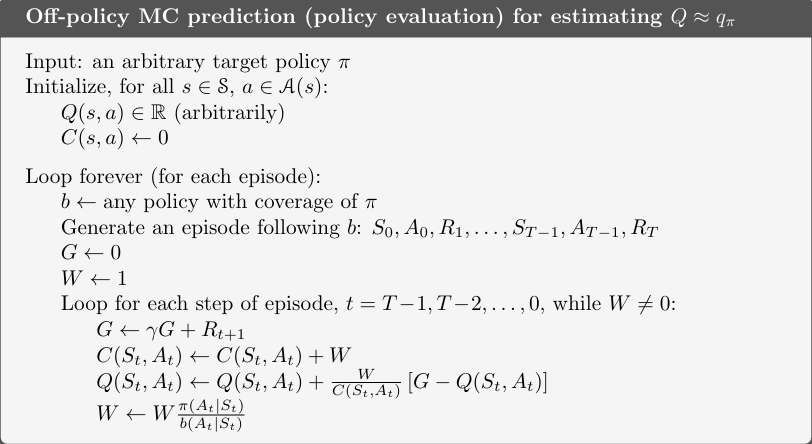

In [9]:
def MC_off(env,target_policy=None,behavior_policy=None,gamma=1,n_episodes=100000):
    Q = {(p,d,a):{0:1,1:1} for p in range(32) for d in range(11) for a in range(2)}
    C = {(p,d,a):{0:0,1:0}  for p in range(32) for d in range(11) for a in range(2)}
    for _ in range(n_episodes):
        states,actions,rewards = generate_episode(env,behavior_policy)
        G = 0
        W = 1
        for t in range(len(states)-1,-1,-1):
            S = states[t]
            A = actions[t]
            G = G*gamma +rewards[t]
            C[S][A]+=W
            Q[S][A] += (W/C[S][A])*(G-Q[S][A])
            if A!=target_policy[S][A]:
                break
            W *= 1/behavior_policy[S][A] # Importance sampling ratio this is not pi(a/s)/b(a/s) 
                                         #because pi(a/s) is always 1(deterministic policy)
            
    return Q

In [10]:
target_policy = {(p,d,a):[0,1] if p<20 else [1,0] for p in range(32) for d in range(11) for a in range(2)}
behaviour_policy = {(p,d,a):[0.5,0.5] for p in range(32) for d in range(11) for a in range(2)}
Q1 = MC_off(env,target_policy,behaviour_policy, n_episodes=500000)

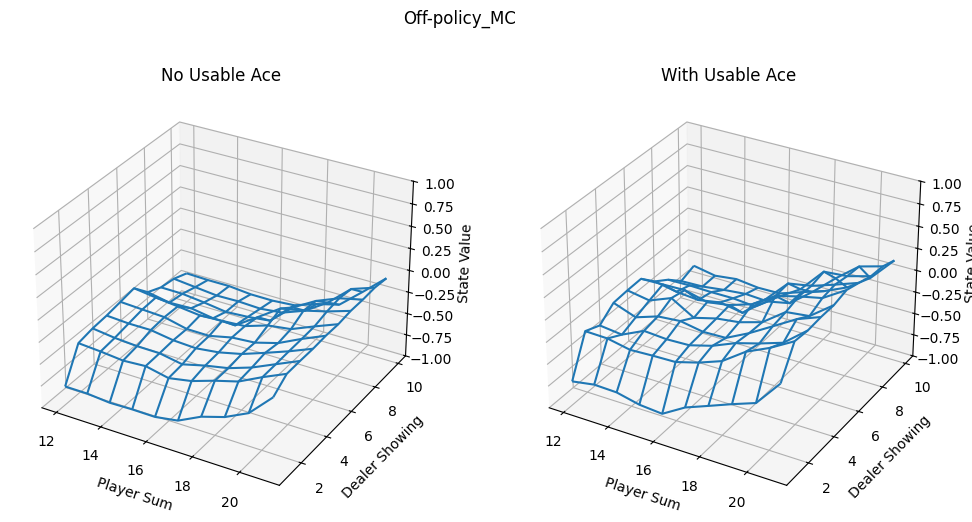

In [11]:
plot_blackjack_Q(Q1,'Off-policy_MC')